# Prophet modeling

Here we'll try to mimic the same process of finding the best train-test split, but for Facebook's Prophet library. Let's import everything.

In [1]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
#from trafalgar import*
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
import datetime as dt
from datetime import date
from datetime import timedelta 
import yfinance as yf
import requests
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
import re
from tiingo import TiingoClient
import json
from pandas_datareader import data as pdr

In [2]:
yf.__version__

'0.1.63'

### The test case: C
Just like the previous notebook, we'll try to run through a simple test case and expand it to other stocks. We'll use Citicgroup again.

Quick note: I encountered a bug with my earlier library, yfinance, so I've had to switch to tiingo, so a lot of code will be hashed out from earlier. And in case I can get the bugs worked out.

In [3]:
c = yf.Ticker("C")

In [4]:
df=c.history(period="2y")

In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-22,65.965877,66.497558,65.928565,66.329659,7930600,0.0,0
2019-07-23,66.534877,67.327735,66.506895,67.150505,11804300,0.0,0
2019-07-24,66.842676,68.167215,66.842676,68.101921,12512900,0.0,0
2019-07-25,68.055285,68.167220,66.161752,66.590828,15698300,0.0,0
2019-07-26,67.299737,67.756795,67.019902,67.309067,10625900,0.0,0


In [6]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-22,65.965877,66.497558,65.928565,66.329659,7930600,0.0,0
2019-07-23,66.534877,67.327735,66.506895,67.150505,11804300,0.0,0
2019-07-24,66.842676,68.167215,66.842676,68.101921,12512900,0.0,0
2019-07-25,68.055285,68.167220,66.161752,66.590828,15698300,0.0,0
2019-07-26,67.299737,67.756795,67.019902,67.309067,10625900,0.0,0


In [7]:
deltas=['d','m','y']
att='200d'

In [8]:
att[-1]

'd'

In [9]:
spl=len(att)-1
att[:spl]

'200'

In [10]:
end=att[:spl] + ' days'
end

'200 days'

In [11]:
df1=df['Close']

In [12]:
df1.head()

Date
2019-07-22    66.329659
2019-07-23    67.150505
2019-07-24    68.101921
2019-07-25    66.590828
2019-07-26    67.309067
Name: Close, dtype: float64

In [13]:
df1=df1.to_frame()

In [14]:
# instantiate Prophet
prof_1 = Prophet()

In [15]:
df1.head()

,Close
Date,
2019-07-22,66.329659
2019-07-23,67.150505
2019-07-24,68.101921
2019-07-25,66.590828
2019-07-26,67.309067


In [16]:
df1.index.names = ['ds']
df1.columns=['y']

In [17]:
df1.reset_index(level=0, inplace=True)

In [18]:
df1.head()

,ds,y
0,2019-07-22,66.329659
1,2019-07-23,67.150505
2,2019-07-24,68.101921
3,2019-07-25,66.590828
4,2019-07-26,67.309067


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      506 non-null    datetime64[ns]
 1   y       506 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [20]:
prof_1.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
#Create a new dataframe for the predictions, 3 weeks out
future = prof_1.make_future_dataframe(periods=21)

In [22]:
forecast = prof_1.predict(future)

In [23]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
522,2021-08-08,75.221873,71.812908,81.104707,74.972228,75.459852,1.195774,1.195774,1.195774,1.652086,1.652086,1.652086,-0.456312,-0.456312,-0.456312,0.0,0.0,0.0,76.417647
523,2021-08-09,75.292011,68.825221,78.755743,75.001984,75.560891,-1.283622,-1.283622,-1.283622,-0.533335,-0.533335,-0.533335,-0.750288,-0.750288,-0.750288,0.0,0.0,0.0,74.008389
524,2021-08-10,75.362149,68.813821,78.827274,75.024008,75.658578,-1.775524,-1.775524,-1.775524,-0.730948,-0.730948,-0.730948,-1.044576,-1.044576,-1.044576,0.0,0.0,0.0,73.586626
525,2021-08-11,75.432288,68.412270,78.549017,75.076825,75.760831,-1.994478,-1.994478,-1.994478,-0.659468,-0.659468,-0.659468,-1.335010,-1.335010,-1.335010,0.0,0.0,0.0,73.437810
526,2021-08-12,75.502426,68.111761,78.271051,75.078017,75.866483,-2.323817,-2.323817,-2.323817,-0.706195,-0.706195,-0.706195,-1.617622,-1.617622,-1.617622,0.0,0.0,0.0,73.178609


In [24]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          527 non-null    datetime64[ns]
 1   trend                       527 non-null    float64       
 2   yhat_lower                  527 non-null    float64       
 3   yhat_upper                  527 non-null    float64       
 4   trend_lower                 527 non-null    float64       
 5   trend_upper                 527 non-null    float64       
 6   additive_terms              527 non-null    float64       
 7   additive_terms_lower        527 non-null    float64       
 8   additive_terms_upper        527 non-null    float64       
 9   weekly                      527 non-null    float64       
 10  weekly_lower                527 non-null    float64       
 11  weekly_upper                527 non-null    float64       

In [25]:
proph_pred=forecast['yhat']

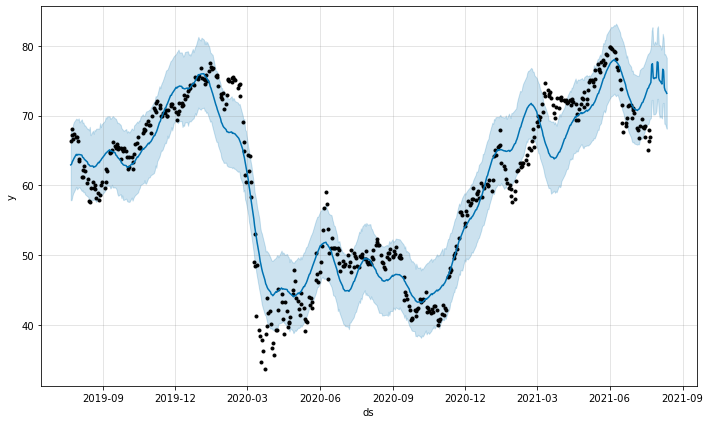

In [26]:
prof_1.plot(forecast)
plt.show()

In [27]:
df1_cv = cross_validation(prof_1, initial='30 days', period='7 days', horizon = '14 days')

INFO:prophet:Making 99 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-08 00:00:00


  0%|          | 0/99 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [28]:
df1_pm = performance_metrics(df1_cv)

In [29]:
trains=['30 days','60 days','180 days']
tests=['7 days','14 days','21 days']

In [30]:
df1_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
4,8 days,299.939991,17.318776,11.819715,0.196839,0.130225,0.194451,0.180684
5,11 days,961.160333,31.002586,18.867193,0.316191,0.172364,0.305642,0.125308
6,12 days,1354.790303,36.807476,21.765605,0.363490,0.189183,0.340397,0.111111
7,13 days,1973.067178,44.419221,25.621233,0.430302,0.217788,0.388603,0.113402
8,14 days,2675.748387,51.727637,28.378834,0.470544,0.212392,0.395549,0.103093


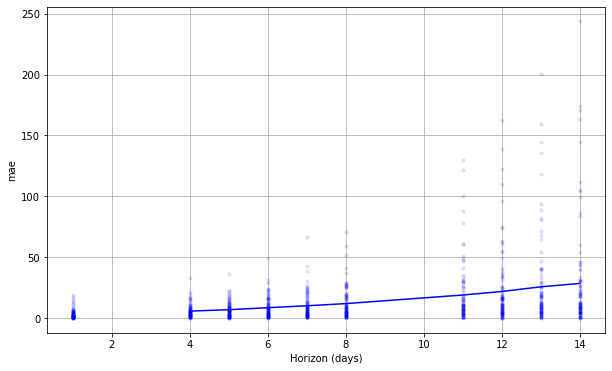

In [31]:
fig = plot_cross_validation_metric(df1_cv, metric='mae')

## STONKS (Again)!!!

Just like in the ARIMA notebook, I want to test a number of train-test splits with Prophet. Since it works a little different from ARIMA, the code will be a little different, but still borrowing a lot. Here, we can import our stock symbols, and clean them up.

In [32]:
sp_500=pd.read_csv('Data/constituents_csv.csv')
nsdq=pd.read_csv('Data/nasdaq1.csv')
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

In [33]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [34]:
nsdq.head()

,Unnamed: 0,Symbol,Company Name
0,0,AAIT,iShares MSCI All Country Asia Information Tech...
1,1,AAL,"American Airlines Group, Inc."
2,2,AAME,Atlantic American Corporation
3,3,AAOI,"Applied Optoelectronics, Inc."
4,4,AAON,"AAON, Inc."


In [35]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [36]:
len(nsdq)

1734

The following cells were necessary for cleaning the nasdaq stock list. But I saved it, and that's what I'm using.

In [37]:
#no_data=[]
#for each in nsdq['Symbol']:
#    x=yf.Ticker(each)
#    df=x.history(period='1d')
#    if len(df)==0:
#        no_data.append(each)

In [38]:
#len(no_data)

In [39]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [40]:
#nsdq = nsdq.drop(labels=nd_index,drop=True, axis=0)
#nsdq.reset_index()

In [41]:
#nsdq.to_csv("/Users/Daniel/Documents/Flatiron/Capstone/Project/nasdaq1.csv")

In [42]:
def tt_test_p (asset,train_val,test_val):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run prophet models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='2y')
    print("Processing: ",stock)
    prof_1 = Prophet()
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof_1.fit(df1)
    future = prof_1.make_future_dataframe(periods=21)
    forecast = prof_1.predict(future)
    for train_val in trains:
        for test_val in tests:
            df1_cv = cross_validation(prof_1, initial=train_val, period=test_val, horizon = '21 days')
            df1_pm = performance_metrics(df1_cv)
            print('Training: ', train_val)
            print('Testing: ', test_val)
            print (df1_pm.tail())             

    return forecast

In [43]:
cols2=['Symbol','Train_Len','Test_Len','MAE','RMSE']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

,index,Symbol,Train_Len,Test_Len,MAE,RMSE


In [44]:
results_CAT=tt_test_p('CAT',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <CAT>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  14081.636698  118.666072   56.370148  0.424938  0.129169   
10 18 days  31779.382010  178.267726   77.124908  0.583894  0.149977   
11 19 days  46985.803870  216.762090   91.371872  0.690002  0.136772   
12 20 days  56904.901220  238.547482   97.103331  0.734245  0.122270   
13 21 days  76548.677425  276.674317  111.848019  0.846784  0.143794   

       smape  coverage  
9   0.342360  0.148936  
10  0.393280  0.121482  
11  0.423197  0.104807  
12  0.439419  0.103488  
13  0.468400  0.089982  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  14225.386401  119.270224   53.696336  0.397086  0.119754   
10 18 days  33796.263333  183.837600   73.806354  0.545734  0.111239   
11 19 days  50635.571903  225.023492   88.239568  0.655285  0.097225   
12 20 days  57806.417415  240.429652   88.612827  0.664990  0.141793   
13 21 days  82679.597762  287.540602  106.924913  0.806204  0.155568   

       smape  coverage  
9   0.305102  0.134402  
10  0.351024  0.099068  
11  0.393283  0.085050  
12  0.407489  0.068513  
13  0.446834  0.049107  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   21289.018757  145.907569   68.820655  0.534181  0.122917   
10 18 days   46619.837476  215.916274   90.872850  0.707162  0.137109   
11 19 days   67402.819403  259.620530  105.842290  0.816667  0.117197   
12 20 days   86356.386011  293.864571  118.141535  0.907733  0.133697   
13 21 days  108480.043632  329.363088  128.849838  0.989780  0.132180   

       smape  coverage  
9   0.344911  0.097739  
10  0.353601  0.078723  
11  0.382096  0.104965  
12  0.411040  0.102515  
13  0.418456  0.070479  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days  12537.516963  111.971054  52.143933  0.389352  0.116175  0.326270   
10 18 days  28244.574650  168.061223  70.026818  0.524561  0.139177  0.364386   
11 19 days  41773.181489  204.384886  82.119698  0.611702  0.134983  0.385777   
12 20 days  50035.039822  223.685135  85.916894  0.639124  0.133445  0.394631   
13 21 days  67964.361046  260.699753  98.839719  0.735644  0.137563  0.416080   

    coverage  
9   0.172298  
10  0.136957  
11  0.110623  
12  0.101669  
13  0.091438  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-10 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days  10582.160725  102.869630  44.751334  0.324306  0.094942  0.268366   
10 18 days  25561.543409  159.879778  59.716962  0.431302  0.105282  0.294652   
11 19 days  38738.869963  196.821924  71.343673  0.516756  0.103774  0.332768   
12 20 days  42655.337705  206.531687  69.476680  0.506732  0.134095  0.348229   
13 21 days  63751.007035  252.489618  85.337902  0.626008  0.134666  0.387161   

    coverage  
9   0.155287  
10  0.112619  
11  0.088824  
12  0.071451  
13  0.051265  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  16322.963491  127.761354   58.464798  0.451291  0.129172   
10 18 days  35584.324810  188.638079   74.152995  0.573262  0.118584   
11 19 days  51361.734168  226.631274   85.086056  0.648104  0.104124   
12 20 days  66023.279630  256.949955   94.503834  0.713551  0.126211   
13 21 days  83207.635307  288.457337  102.215648  0.769518  0.126175   

       smape  coverage  
9   0.323397  0.127273  
10  0.320809  0.097403  
11  0.344550  0.112013  
12  0.371410  0.109238  
13  0.376310  0.075000  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-30 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1845.480316  42.959054  26.378122  0.197642  0.083046  0.192440   
10 18 days  2623.039243  51.215615  29.458428  0.226645  0.083046  0.209472   
11 19 days  3133.402553  55.976804  31.562902  0.241378  0.089305  0.226127   
12 20 days  3439.504762  58.647291  32.998636  0.249614  0.096818  0.236796   
13 21 days  3813.937498  61.757085  34.454501  0.260913  0.099329  0.244475   

    coverage  
9   0.193818  
10  0.159155  
11  0.135705  
12  0.122488  
13  0.101316  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days   844.415393  29.058826  21.353366  0.150006  0.080631  0.167027   
10 18 days   934.505871  30.569689  22.416441  0.156593  0.075015  0.170099   
11 19 days  1195.094502  34.570139  24.732547  0.174926  0.090316  0.198824   
12 20 days  1398.035494  37.390313  26.663914  0.189184  0.097795  0.219781   
13 21 days  1575.793505  39.696266  27.850901  0.199015  0.088908  0.229328   

    coverage  
9   0.175926  
10  0.129630  
11  0.109989  
12  0.086745  
13  0.061891  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  3065.019745  55.362620  31.218013  0.251450  0.102076  0.209599   
10 18 days  4430.523137  66.562175  33.920783  0.279765  0.117197  0.199091   
11 19 days  5287.009273  72.711823  36.203366  0.291335  0.097113  0.226097   
12 20 days  5913.710726  76.900655  38.232270  0.299202  0.093696  0.248777   
13 21 days  6504.887295  80.652882  39.843000  0.304486  0.108372  0.256124   

    coverage  
9   0.126486  
10  0.099882  
11  0.132883  
12  0.126819  
13  0.088358  


In [45]:
results_MMM=tt_test_p('MMM',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <MMM>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   19584.880196  139.945990   65.706700  0.421617  0.114499   
10 18 days   44393.525044  210.697710   91.652212  0.587120  0.129993   
11 19 days   65513.379084  255.955815  108.511197  0.692952  0.118303   
12 20 days   84341.588569  290.416233  120.643289  0.770383  0.117025   
13 21 days  101195.123900  318.111810  127.992282  0.821257  0.135961   

       smape  coverage  
9   0.348675  0.195035  
10  0.406874  0.204759  
11  0.429670  0.184949  
12  0.438039  0.154653  
13  0.439478  0.152926  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  21890.510708  147.954421   69.194706  0.437402  0.120160   
10 18 days  48710.894268  220.705447   97.444791  0.615167  0.100111   
11 19 days  70245.724988  265.039101  114.567717  0.726643  0.091700   
12 20 days  87987.145732  296.626273  125.752459  0.799766  0.122913   
13 21 days  97914.025689  312.912169  127.899716  0.819148  0.130091   

       smape  coverage  
9   0.348159  0.219825  
10  0.396171  0.212422  
11  0.409796  0.205648  
12  0.410555  0.164140  
13  0.400796  0.190774  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   24820.841789  157.546316   74.524774  0.483124  0.125160   
10 18 days   52178.228716  228.425543  101.553609  0.663267  0.125160   
11 19 days   73151.750573  270.465803  117.172517  0.761008  0.127459   
12 20 days   91521.833693  302.525757  129.590143  0.840341  0.132394   
13 21 days  112210.832575  334.978854  141.705236  0.921339  0.135961   

       smape  coverage  
9   0.301350  0.097739  
10  0.380970  0.142553  
11  0.418906  0.177305  
12  0.432818  0.206963  
13  0.441331  0.214096  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  15922.971376  126.186257   59.160930  0.380625  0.108886   
10 18 days  36750.157663  191.703306   81.717038  0.524269  0.115550   
11 19 days  54722.333440  233.928052   96.227145  0.613473  0.117577   
12 20 days  71001.925831  266.461866  106.540190  0.677832  0.125075   
13 21 days  84485.226879  290.663425  111.434479  0.712460  0.132506   

       smape  coverage  
9   0.335183  0.198458  
10  0.383683  0.216588  
11  0.397859  0.195259  
12  0.402011  0.155673  
13  0.399317  0.165245  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-10 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days  13585.748564  116.557919  54.348527  0.344498  0.109078  0.317553   
10 18 days  30873.901610  175.709708  74.940056  0.473486  0.097135  0.358241   
11 19 days  45030.441320  212.203773  87.820526  0.555502  0.103086  0.369437   
12 20 days  57078.982090  238.912080  96.266050  0.608792  0.120351  0.368682   
13 21 days  58726.595865  242.335709  93.866890  0.597989  0.131277  0.355459   

    coverage  
9   0.229597  
10  0.237449  
11  0.222060  
12  0.186091  
13  0.206360  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  13169.203105  114.757148   55.826421  0.366923  0.117635   
10 18 days  27979.200307  167.269843   74.047688  0.490965  0.119911   
11 19 days  39290.584946  198.218528   84.647457  0.554015  0.122881   
12 20 days  49556.100233  222.611995   93.196947  0.606952  0.119744   
13 21 days  61320.655340  247.630078  101.421784  0.662492  0.136810   

       smape  coverage  
9   0.254018  0.104545  
10  0.309971  0.152597  
11  0.332805  0.189123  
12  0.343262  0.197947  
13  0.352341  0.218182  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-30 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  2379.554256  48.780675  26.774863  0.177557  0.080437  0.188989   
10 18 days  3670.144472  60.581717  30.939552  0.210085  0.081530  0.217636   
11 19 days  4461.591141  66.795143  33.544754  0.225975  0.090182  0.229607   
12 20 days  5007.171748  70.761372  35.685683  0.238131  0.099967  0.236123   
13 21 days  5615.231877  74.934851  37.510835  0.251431  0.088989  0.241987   

    coverage  
9   0.248727  
10  0.267222  
11  0.239657  
12  0.187321  
13  0.199880  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days   776.707184  27.869467  18.624050  0.117959  0.077260  0.136504   
10 18 days  1169.635852  34.199939  20.450709  0.130420  0.058023  0.161755   
11 19 days  1521.112360  39.001440  22.770487  0.147077  0.069289  0.181461   
12 20 days  1899.786529  43.586541  25.174704  0.162228  0.116819  0.191778   
13 21 days  2309.106101  48.053159  26.854964  0.174131  0.069827  0.198267   

    coverage  
9   0.277778  
10  0.296296  
11  0.274972  
12  0.207602  
13  0.243177  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  3062.190947  55.337067  30.229309  0.208318  0.106569  0.185546   
10 18 days  5191.534134  72.052301  36.120251  0.258644  0.108049  0.232170   
11 19 days  6198.650465  78.731509  38.515857  0.270194  0.108870  0.247998   
12 20 days  7115.455506  84.353159  40.642993  0.280432  0.085540  0.251635   
13 21 days  8156.990674  90.316060  42.913675  0.294125  0.114600  0.256440   

    coverage  
9   0.126486  
10  0.180964  
11  0.224099  
12  0.230769  
13  0.257796  


In [46]:
results_AXP=tt_test_p('AXP',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AXP>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   7109.748458   84.319324  44.277285  0.406533  0.140316  0.351291   
10 18 days  15766.688340  125.565474  60.672086  0.557334  0.156489  0.400720   
11 19 days  23081.211832  151.925020  71.519858  0.648293  0.130631  0.420585   
12 20 days  29375.300453  171.392242  77.989923  0.701150  0.127520  0.423625   
13 21 days  34074.722776  184.593399  82.493604  0.738984  0.158063  0.435804   

    coverage  
9   0.180851  
10  0.164722  
11  0.171395  
12  0.204299  
13  0.232934  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   7015.243664   83.757051  45.169863  0.396576  0.112557  0.338232   
10 18 days  16107.155856  126.913970  63.269358  0.555115  0.121081  0.389113   
11 19 days  23746.288093  154.098307  74.293991  0.652938  0.122958  0.407195   
12 20 days  29704.136228  172.348879  78.656835  0.696477  0.183258  0.395122   
13 21 days  31041.213798  176.185169  79.551065  0.707424  0.194979  0.401357   

    coverage  
9   0.169971  
10  0.130124  
11  0.163455  
12  0.200583  
13  0.239881  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days  10961.651421  104.697906  55.659261  0.528491  0.121489  0.335663   
10 18 days  22804.295842  151.010913  73.792809  0.708800  0.105889  0.362296   
11 19 days  31936.728457  178.708501  84.384389  0.788893  0.090174  0.376885   
12 20 days  40305.511091  200.762325  92.685556  0.845596  0.126093  0.392271   
13 21 days  50145.091431  223.930997  99.409960  0.898093  0.133221  0.391278   

    coverage  
9   0.141622  
10  0.112057  
11  0.093617  
12  0.199226  
13  0.244681  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   5304.482373   72.831877  36.852474  0.342213  0.119812  0.312319   
10 18 days  11236.002568  106.000012  48.369880  0.450285  0.124324  0.346544   
11 19 days  16155.326411  127.103605  55.975606  0.511900  0.121397  0.361216   
12 20 days  20181.723171  142.062392  59.924037  0.542365  0.142165  0.363162   
13 21 days  21732.552298  147.419647  61.249499  0.552483  0.149234  0.373816   

    coverage  
9   0.187387  
10  0.181733  
11  0.184460  
12  0.215375  
13  0.245695  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-10 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   5381.328950   73.357542  38.877820  0.342305  0.110500  0.316125   
10 18 days  12672.516445  112.572272  53.866140  0.473181  0.117752  0.360831   
11 19 days  18960.751465  137.698045  63.232396  0.556721  0.126041  0.376786   
12 20 days  23830.697208  154.371944  66.367931  0.589001  0.160235  0.362424   
13 21 days  23387.855629  152.930885  65.294581  0.581759  0.165906  0.366113   

    coverage  
9   0.177517  
10  0.121438  
11  0.163451  
12  0.224198  
13  0.257625  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   6712.859311   81.932041  40.933744  0.401040  0.119809  0.251271   
10 18 days  12778.427728  113.041708  50.842083  0.508792  0.102951  0.272013   
11 19 days  17091.981238  130.736304  56.475540  0.542873  0.116974  0.290241   
12 20 days  20964.607727  144.791601  60.823390  0.564441  0.123691  0.305832   
13 21 days  25420.299119  159.437446  63.341322  0.580004  0.130567  0.304280   

    coverage  
9   0.151515  
10  0.120130  
11  0.099838  
12  0.212610  
13  0.260606  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-30 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1973.367560  44.422602  23.096423  0.231412  0.097012  0.216633   
10 18 days  3030.645492  55.051299  27.064228  0.277904  0.092799  0.239419   
11 19 days  3589.645524  59.913651  29.183994  0.291797  0.094227  0.249986   
12 20 days  3883.598709  62.318526  30.206382  0.295548  0.122631  0.256809   
13 21 days  4377.735260  66.164456  31.403424  0.307262  0.089988  0.263007   

    coverage  
9   0.235636  
10  0.215109  
11  0.221739  
12  0.260048  
13  0.297010  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1101.356012  33.186684  20.254910  0.187390  0.091955  0.196220   
10 18 days  1518.064538  38.962348  23.646563  0.221055  0.092343  0.217219   
11 19 days  1748.554572  41.815722  25.453883  0.241525  0.113280  0.230372   
12 20 days  1854.966134  43.069318  26.350352  0.255120  0.124182  0.240819   
13 21 days  2100.025030  45.826030  27.537672  0.271408  0.084656  0.249988   

    coverage  
9   0.231481  
10  0.170370  
11  0.211560  
12  0.273879  
13  0.313353  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  3738.033148  61.139457  27.121142  0.294049  0.085462  0.193497   
10 18 days  5950.460775  77.139230  32.295357  0.364414  0.100432  0.209364   
11 19 days  7004.182022  83.690991  35.060414  0.372086  0.090174  0.228440   
12 20 days  7691.765901  87.702713  36.724913  0.367572  0.087195  0.241666   
13 21 days  8623.657669  92.863651  38.043273  0.375487  0.119891  0.246816   

    coverage  
9   0.183784  
10  0.142186  
11  0.118243  
12  0.250520  
13  0.307692  


In [47]:
results_AAPL=tt_test_p('AAPL',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AAPL>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2280.819602   47.757927  27.683946  0.398606  0.097443  0.350964   
10 18 days   4965.219413   70.464313  37.650713  0.555663  0.139601  0.419327   
11 19 days   7300.343269   85.442046  44.766469  0.660672  0.110273  0.449069   
12 20 days   8781.417376   93.709217  47.460545  0.702236  0.095616  0.446265   
13 21 days  11718.787054  108.253347  53.364706  0.789605  0.110193  0.463596   

    coverage  
9   0.131206  
10  0.138870  
11  0.143341  
12  0.151976  
13  0.120789  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2400.221978   48.992060  29.132708  0.419009  0.105096  0.379178   
10 18 days   5459.017862   73.885167  39.373054  0.580966  0.102269  0.433789   
11 19 days   8177.059723   90.427096  46.834577  0.693175  0.098624  0.453842   
12 20 days   9278.316918   96.324020  47.776921  0.711746  0.109629  0.443134   
13 21 days  12888.901828  113.529299  54.572367  0.811508  0.104695  0.453207   

    coverage  
9   0.120408  
10  0.127640  
11  0.156146  
12  0.165598  
13  0.126190  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2640.965929   51.390329  26.519505  0.389227  0.103966  0.287681   
10 18 days   5463.575131   73.916001  35.515835  0.535368  0.084425  0.365202   
11 19 days   7735.591313   87.952210  42.087098  0.626938  0.094919  0.409007   
12 20 days   9825.471338   99.123516  46.036139  0.684408  0.089502  0.398666   
13 21 days  12340.194132  111.086426  51.247882  0.755518  0.079937  0.416175   

    coverage  
9   0.206782  
10  0.263830  
11  0.238298  
12  0.195358  
13  0.140957  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  7 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2155.511930   46.427491  26.407547  0.368283  0.097341  0.338345   
10 18 days   4705.226276   68.594652  35.640764  0.510725  0.100730  0.394296   
11 19 days   6934.760696   83.275211  42.285353  0.606498  0.102006  0.418278   
12 20 days   8285.795332   91.026344  44.519772  0.639270  0.107213  0.414438   
13 21 days  11122.704945  105.464235  50.039831  0.718850  0.098123  0.431444   

    coverage  
9   0.123667  
10  0.138569  
11  0.143810  
12  0.141871  
13  0.120469  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-10 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  14 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2167.662594   46.558164  27.203684  0.377947  0.088661  0.364465   
10 18 days   4933.834380   70.241258  36.532645  0.522555  0.084425  0.417426   
11 19 days   7409.046710   86.075820  43.540427  0.626607  0.099226  0.438118   
12 20 days   8235.971527   90.752254  44.006250  0.635123  0.099226  0.427545   
13 21 days  11593.264948  107.672025  50.438800  0.726750  0.112497  0.438722   

    coverage  
9   0.125754  
10  0.133650  
11  0.148162  
12  0.166084  
13  0.116807  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse        mae      mape     mdape     smape  \
9  15 days   2783.195490   52.756000  26.686585  0.385712  0.082646  0.275753   
10 18 days   5747.414725   75.811706  35.628135  0.529823  0.067482  0.325581   
11 19 days   8099.357789   89.996432  42.145435  0.618950  0.104749  0.360496   
12 20 days  10256.212447  101.272960  46.014507  0.674536  0.082259  0.352288   
13 21 days  12823.977144  113.243000  51.161807  0.743925  0.078701  0.374756   

    coverage  
9   0.221212  
10  0.259740  
11  0.243506  
12  0.230938  
13  0.182576  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-30 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days   707.761727  26.603792  14.891014  0.180287  0.069788  0.177853   
10 18 days  1030.328909  32.098737  16.744380  0.209431  0.075951  0.210108   
11 19 days  1279.325114  35.767655  18.491381  0.228341  0.075796  0.231680   
12 20 days  1436.280843  37.898296  19.376898  0.237973  0.084419  0.238747   
13 21 days  1594.489014  39.931053  20.043769  0.247508  0.078701  0.245878   

    coverage  
9   0.166182  
10  0.166837  
11  0.181028  
12  0.193301  
13  0.144617  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  14 days
   horizon         mse       rmse        mae      mape     mdape     smape  \
9  15 days  383.807468  19.591005  13.238439  0.152348  0.068940  0.184770   
10 18 days  474.015771  21.771903  14.037651  0.164695  0.075286  0.216323   
11 19 days  674.428901  25.969769  15.851923  0.187623  0.075860  0.238635   
12 20 days  807.125810  28.409960  16.894739  0.201386  0.087061  0.242730   
13 21 days  918.964339  30.314425  17.705792  0.212523  0.071885  0.246675   

    coverage  
9   0.157407  
10  0.166667  
11  0.183502  
12  0.202729  
13  0.158869  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1277.043885  35.735751  15.463019  0.208922  0.055044  0.146853   
10 18 days  1997.632376  44.694881  18.010791  0.254322  0.057322  0.178220   
11 19 days  2352.152423  48.498994  19.901919  0.268780  0.066599  0.205109   
12 20 days  2616.891921  51.155566  20.748189  0.275716  0.054789  0.209722   
13 21 days  2899.093881  53.843234  21.789390  0.284642  0.073753  0.212504   

    coverage  
9   0.252973  
10  0.334900  
11  0.300676  
12  0.269231  
13  0.188150  


In [48]:
results_AMGN=tt_test_p('AMGN',trains,tests)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing:  yfinance.Ticker object <AMGN>


INFO:prophet:Making 98 forecasts with cutoffs between 2019-08-22 00:00:00 and 2021-07-01 00:00:00


  0%|          | 0/98 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Making 49 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   47387.335007  217.686323   98.050944  0.477810  0.065042   
10 18 days  111477.207504  333.882026  144.202129  0.706353  0.096972   
11 19 days  166108.985762  407.564701  173.106623  0.849318  0.097685   
12 20 days  212000.000810  460.434578  190.238848  0.939273  0.080261   
13 21 days  263122.673281  512.954845  208.081856  1.030818  0.090589   

       smape  coverage  
9   0.322126  0.152482  
10  0.360104  0.153054  
11  0.365508  0.150118  
12  0.365036  0.123607  
13  0.363188  0.157137  


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 33 forecasts with cutoffs between 2019-08-29 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   41683.632756  204.165699   95.242582  0.465289  0.069900   
10 18 days  103135.708891  321.147488  144.800438  0.709194  0.089450   
11 19 days  155095.285161  393.821387  173.575342  0.848223  0.070293   
12 20 days  194702.535133  441.251102  184.807881  0.911514  0.079188   
13 21 days  235511.293782  485.295058  198.364430  0.982030  0.077180   

       smape  coverage  
9   0.337938  0.162682  
10  0.389047  0.164596  
11  0.389451  0.127243  
12  0.375844  0.103499  
13  0.367323  0.148512  


  0%|          | 0/33 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Making 93 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  30 days
Testing:  21 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   31625.804125  177.836453   83.734651  0.415045  0.073530   
10 18 days   82817.603884  287.780479  126.182440  0.632879  0.090390   
11 19 days  128464.559387  358.419530  151.552368  0.758204  0.082869   
12 20 days  173422.891507  416.440742  173.171699  0.867036  0.076147   
13 21 days  229063.485672  478.605773  194.740719  0.973048  0.091701   

       smape  coverage  
9   0.325498  0.141622  
10  0.353914  0.154610  
11  0.344332  0.134752  
12  0.351019  0.123791  
13  0.353224  0.164894  


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:prophet:Making 47 forecasts with cutoffs between 2019-09-26 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  7 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   29918.833698  172.970615   74.236551  0.350217  0.074184   
10 18 days   67937.339027  260.647922  105.733290  0.498741  0.081657   
11 19 days   99833.750646  315.964793  124.591808  0.585603  0.093202   
12 20 days  125079.989805  353.666495  133.947300  0.631272  0.089340   
13 21 days  149583.116147  386.759765  142.504516  0.672778  0.084632   

       smape  coverage  
9   0.262958  0.168690  
10  0.296726  0.173423  
11  0.301199  0.162072  
12  0.298452  0.130396  
13  0.293442  0.165655  


  0%|          | 0/47 [00:00<?, ?it/s]

INFO:prophet:Making 31 forecasts with cutoffs between 2019-10-10 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  14 days
   horizon            mse        rmse         mae      mape     mdape  \
9  15 days   25787.707581  160.585515   71.516393  0.335537  0.061096   
10 18 days   60573.379735  246.116598  105.545762  0.493591  0.066271   
11 19 days   89205.029399  298.672110  124.794409  0.581434  0.079294   
12 20 days  108060.914961  328.726201  129.196153  0.605346  0.078115   
13 21 days  119615.372989  345.854555  133.139822  0.624629  0.077081   

       smape  coverage  
9   0.280728  0.184821  
10  0.326509  0.181140  
11  0.328650  0.147798  
12  0.315036  0.114640  
13  0.304044  0.155094  


  0%|          | 0/31 [00:00<?, ?it/s]

INFO:prophet:Making 76 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  60 days
Testing:  21 days
   horizon           mse        rmse         mae      mape     mdape  \
9  15 days  13885.998953  117.838869   53.362524  0.249014  0.065395   
10 18 days  28810.810995  169.737477   73.003704  0.344045  0.079869   
11 19 days  40469.147334  201.169449   82.885800  0.387270  0.072497   
12 20 days  51609.819054  227.177946   92.293726  0.429814  0.082308   
13 21 days  64758.374053  254.476667  100.833747  0.467404  0.077335   

       smape  coverage  
9   0.208756  0.174242  
10  0.236286  0.178571  
11  0.234104  0.120942  
12  0.242247  0.121701  
13  0.245920  0.175758  


  0%|          | 0/76 [00:00<?, ?it/s]

INFO:prophet:Making 38 forecasts with cutoffs between 2020-01-30 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  7 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1499.850815  38.727907  22.559377  0.102177  0.059832  0.103712   
10 18 days  2169.268371  46.575405  25.522071  0.116430  0.064758  0.119239   
11 19 days  2518.638853  50.186042  26.934470  0.122711  0.075806  0.125265   
12 20 days  2688.212431  51.847974  28.145261  0.128379  0.076060  0.129037   
13 21 days  2993.865664  54.716229  28.760361  0.131625  0.077802  0.130002   

    coverage  
9   0.198909  
10  0.199360  
11  0.185375  
12  0.152871  
13  0.182416  


  0%|          | 0/38 [00:00<?, ?it/s]

INFO:prophet:Making 26 forecasts with cutoffs between 2020-01-23 00:00:00 and 2021-07-01 00:00:00


Training:  180 days
Testing:  14 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days   959.324411  30.972963  18.225613  0.082207  0.051678  0.097485   
10 18 days  1462.988791  38.249036  20.798806  0.093625  0.065086  0.117545   
11 19 days  1723.668977  41.517093  22.618245  0.101869  0.065881  0.126464   
12 20 days  1866.964293  43.208382  24.432630  0.110635  0.076713  0.131964   
13 21 days  2177.819516  46.667114  25.235003  0.113559  0.066191  0.133555   

    coverage  
9   0.212963  
10  0.214815  
11  0.164422  
12  0.131579  
13  0.171053  


  0%|          | 0/26 [00:00<?, ?it/s]

Training:  180 days
Testing:  21 days
   horizon          mse       rmse        mae      mape     mdape     smape  \
9  15 days  1113.579002  33.370331  20.950030  0.095849  0.051149  0.089028   
10 18 days  1525.985051  39.063859  23.947707  0.111502  0.079294  0.101905   
11 19 days  1564.089275  39.548569  24.571217  0.112192  0.079294  0.104434   
12 20 days  1745.341699  41.777287  26.117422  0.119420  0.076147  0.110906   
13 21 days  1872.341594  43.270563  27.370840  0.125123  0.085423  0.116411   

    coverage  
9   0.156757  
10  0.153937  
11  0.130631  
12  0.142412  
13  0.153846  


After looking over these results, it seems unlike ARIMA, Prophet likes the 180/7 split. Although it doesn't matter that much when using Prophet; it automatically takes all the data available and uses it. The train/test split is mainly used here for cross-validation.

### Putting it all together

So let's make us a function! Ultimately, we'll want it to be able to select the best of 4 stocks input by the user. As always, let's start simple.

In [49]:
results_AMGN.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
521,2021-08-08,229.728690,232.846488,248.777844,229.150404,230.175757,11.104362,11.104362,11.104362,2.752136,2.752136,2.752136,8.352226,8.352226,8.352226,0.0,0.0,0.0,240.833052
522,2021-08-09,229.633713,228.852723,245.428324,228.993875,230.155174,7.474945,7.474945,7.474945,-1.059438,-1.059438,-1.059438,8.534383,8.534383,8.534383,0.0,0.0,0.0,237.108659
523,2021-08-10,229.538737,228.747299,245.012943,228.852219,230.105378,7.798091,7.798091,7.798091,-1.003857,-1.003857,-1.003857,8.801948,8.801948,8.801948,0.0,0.0,0.0,237.336828
524,2021-08-11,229.443760,230.008994,245.361434,228.599488,230.100186,8.057594,8.057594,8.057594,-1.089640,-1.089640,-1.089640,9.147234,9.147234,9.147234,0.0,0.0,0.0,237.501354
525,2021-08-12,229.348784,229.707544,245.486597,228.417961,230.087677,8.162935,8.162935,8.162935,-1.397763,-1.397763,-1.397763,9.560698,9.560698,9.560698,0.0,0.0,0.0,237.511719


In [50]:
pred_cols=['ds','yhat']

In [51]:
AMGN_preds=results_AMGN[pred_cols]

In [52]:
AMGN_preds.tail()

,ds,yhat
521,2021-08-08,240.833052
522,2021-08-09,237.108659
523,2021-08-10,237.336828
524,2021-08-11,237.501354
525,2021-08-12,237.511719


In [53]:
AMGN_preds=AMGN_preds.tail(21)

In [54]:
AMGN_preds.head()

,ds,yhat
505,2021-07-23,246.003762
506,2021-07-24,248.921539
507,2021-07-25,248.109571
508,2021-07-26,243.474530
509,2021-07-27,242.708102


In [55]:
AMGN_preds.reset_index(level=0, drop=True,inplace=True)

In [56]:
AMGN_preds.head()

,ds,yhat
0,2021-07-23,246.003762
1,2021-07-24,248.921539
2,2021-07-25,248.109571
3,2021-07-26,243.474530
4,2021-07-27,242.708102


In [57]:
AMGN_preds['yhat'][20]

237.51171863532227

In [58]:
AMGN_preds['yhat'][0]

246.00376195404905

In [59]:
change_percent=((AMGN_preds['yhat'][20]-AMGN_preds['yhat'][0])/AMGN_preds['yhat'][0])*100

In [60]:
change_percent=round(change_percent,2)

In [61]:
change_percent

-3.45

In [62]:
def pct_change(df):
    """This function will quickly calculate the percentage change from the predictions dataframe.
    One that has been produced from the earlier Prophet function"""
    df1=df['yhat']
    df1=df1.tail(21)
    df1.reset_index(level=0, drop=True,inplace=True)
    change=((df1[20]-df1[0])/df1[0])*100
    change=round(change, 2)
    if change >0:
        print(f"According to the model, you stand to gain {change}% over the next 21 days")
    else:
        change_abs=abs(change)
        print(f"According to the model, you stand to lose {change_abs}% over the next 21 days")
    return None

In [63]:
pct_change(results_AAPL)

According to the model, you stand to gain 5.16% over the next 21 days


In [64]:
pct_change(results_AXP)

According to the model, you stand to gain 2.04% over the next 21 days


In [65]:
pct_change(results_MMM)

According to the model, you stand to lose 2.58% over the next 21 days


In [66]:
pct_change(results_CAT)

According to the model, you stand to lose 6.2% over the next 21 days


In [67]:
def fcast(stock):
    """This function will take a stock and perform Prophet modeling on it and return the forecast dataframe"""
    stock=stock.upper() #make sure the symbol is in uppercase
    prof=Prophet()
    stonk = yf.Ticker(stock)
    df1=stonk.history(period='1y')
    df1=df1['Close']
    df1=df1.to_frame()
    df1.index.names = ['ds']
    df1.columns=['y']
    df1.reset_index(level=0, inplace=True)
    prof.fit(df1)
    future = prof.make_future_dataframe(periods=21)
    forecast = prof.predict(future)
    #The next 2 lines are disabled for the final function
#    prof.plot(forecast)
 #   plt.show()
    return forecast

In [68]:
HAL=fcast('HAL')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
HAL.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-23,15.361697,13.585789,17.189172,15.361697,15.361697,0.089397,0.089397,0.089397,0.089397,0.089397,0.089397,0.0,0.0,0.0,15.451094
1,2020-07-24,15.334423,13.693948,17.211390,15.334423,15.334423,0.121897,0.121897,0.121897,0.121897,0.121897,0.121897,0.0,0.0,0.0,15.456320
2,2020-07-27,15.252602,13.648942,17.229513,15.252602,15.252602,0.136222,0.136222,0.136222,0.136222,0.136222,0.136222,0.0,0.0,0.0,15.388825
3,2020-07-28,15.225329,13.586955,17.128831,15.225329,15.225329,0.177682,0.177682,0.177682,0.177682,0.177682,0.177682,0.0,0.0,0.0,15.403011
4,2020-07-29,15.198055,13.707243,17.450188,15.198055,15.198055,0.266268,0.266268,0.266268,0.266268,0.266268,0.266268,0.0,0.0,0.0,15.464323


In [70]:
MMM=fcast('MMM')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
AXP=fcast('AXP')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
def pred_4():
    """This function will prompt the user to input 4 different stock/ETF symbols. It will then use Prophet 
    to forecast the next 21 days of the stock price, and return the values (in percent) of potential gain and loss."""
    stocks=[]
    pcts=[]
    stock1,stock2,stock3,stock4=input("Enter 4 stock symbols: ").split(",")
    stocks=[stock1,stock2,stock3,stock4]
    for stock in stocks:
        stock=stock.upper()
        df=fcast(stock)
        df1=df['yhat']
        df1=df1.tail(21)
        df1.reset_index(level=0, drop=True,inplace=True)
        change=((df1[20]-df1[0])/df1[0])*100
        change=round(change, 2)
        pcts.append(change)
    for i in range(0,4):
        print(f"Stock: {stocks[i].upper()}")
        print(f"Percent Change: {pcts[i]}")
    maxp=pcts.index(max(pcts))
    print()
    print(f'According to the model, {stocks[maxp].upper()} has the highest upside.')
    print("\n" * 3)
    print('FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.') 
    print('The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.')
    return None
    

In [73]:
pred_4()

Enter 4 stock symbols: amzn,msft,f,t


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Stock: AMZN
Percent Change: 2.34
Stock: MSFT
Percent Change: 2.61
Stock: F
Percent Change: 2.84
Stock: T
Percent Change: -2.86

According to the model, F has the highest upside.




FOR ENTERTAINMENT PURPOSES ONLY. This does not substitute for advise from a financial advisor.
The creator and affiliates are not responsible for any potential losses. But totally responsible for any gains.
